In [1]:
import compton.Dataloader as dl
from compton.Functions import *
from uncertainties import ufloat
from positron.Analysis import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd
from compton.Analysis import *

,Channel,Energy (keV),Counts
0,1,0.755920,0
1,2,1.511840,0
2,3,2.267760,0
3,4,3.023679,0
4,5,3.779599,0


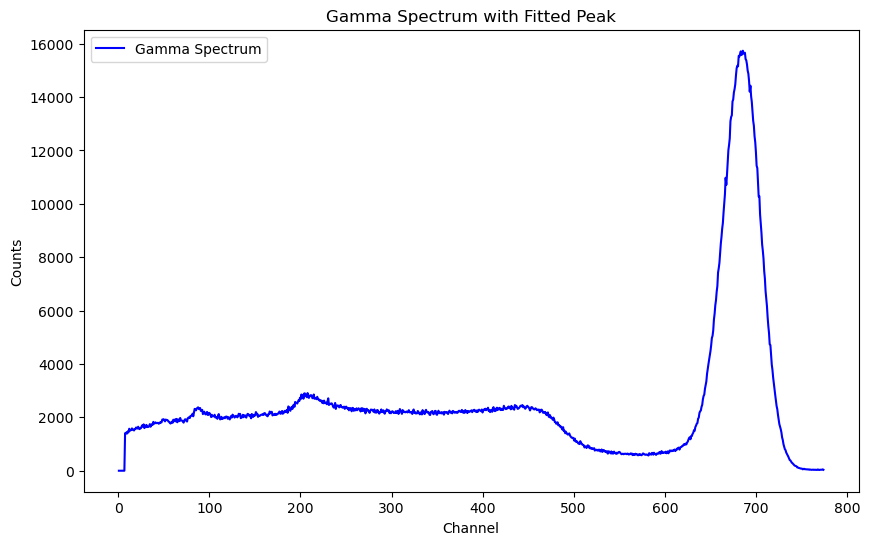

In [2]:
# Load data
control = dl.load_gamma_count('../Databases/Compton/BBL_S0_A0.csv')
display(control.head())

data = control.values  # Convert DataFrame to NumPy array
energy = control['Energy (keV)'].to_numpy()
counts = control['Counts'].to_numpy()

# Plot raw data
plt.figure(figsize=(10, 6))
plt.plot(energy, counts, label='Gamma Spectrum', color='blue')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Gamma Spectrum with Fitted Peak')
plt.legend()
plt.show()


[-871.91910942 1565.98320894   29.46324446  488.43852842]


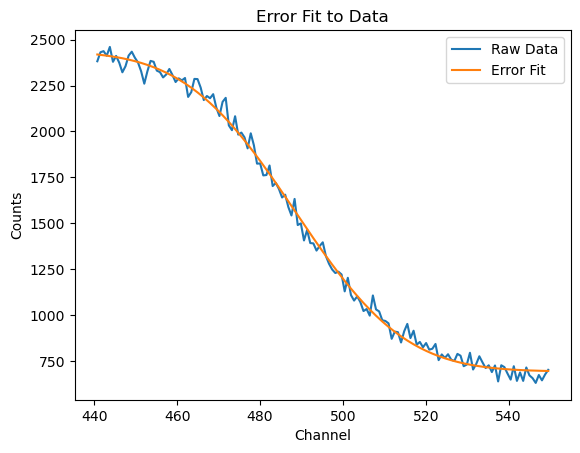

error function center: 488.4385284171225, uncertainty 0.30720389279248217


In [3]:
#Trim ROi for error function regression fit on compton edge
edge_trim_df = trim_df(control, 440, 550)
popt, pcov = error_fit(edge_trim_df)
print(popt)
plot_error_fit(edge_trim_df,)
print(f"error function center: {popt[3]}, uncertainty {np.sqrt(pcov[3][3])}")


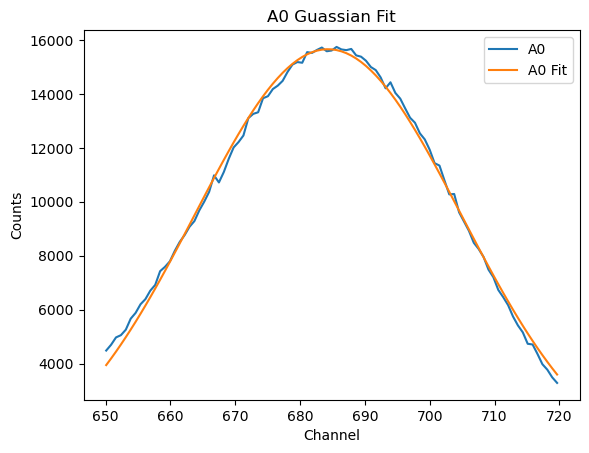

,Angle,Mean,Sigma,Unc Mean,Unc Sigma
0,0,684.296773,20.602211,0.068132,0.081061


In [4]:
#trim ROI for guassian fit
guass_trim_df = trim_df(control, 650, 720)
plot_guassian_fit(guass_trim_df, channel=True)
baseline = run_all_S1_fits([guass_trim_df])

display(baseline)
#E = baseline['Mean'][0]
#sig_E = baseline['Unc Mean'][0]


Next, we have to use the location of these peaks and their known values to obtain the linear calibration curve for the energies

0.9803097343693785 -8.822787609324406


/home/lucas/repos/advanced_exp/compton/Analysis.py:164: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, x, y,)


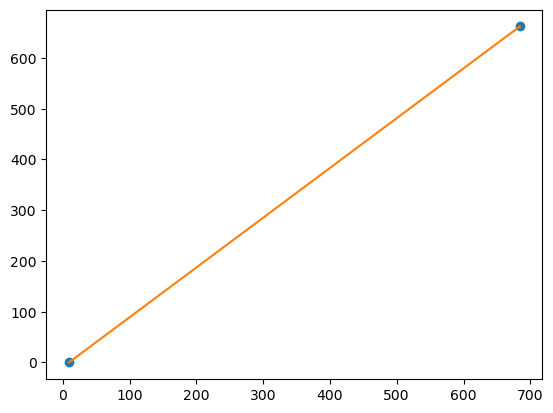

In [5]:
known = 662
slope, intercept, _, _ = compton_calibration(baseline, known)
print(slope, intercept,)

The following cell runs analysis of each of the S1 datasets (scattering material included) for each angle, reporting in a dataframe.

In [6]:
angles = range(0,140, 10)
all_info = []
calibration_params = [slope, intercept]
for ii in range(len(angles)):
    data = dl.load_gamma_count('../Databases/Compton/BBL_S1_A' + str(angles[ii]) + '.csv', rescale = calibration_params) #note the data is recalibrated now by energy level
    all_info.append(data)
#if you want to NOT recalibrate the data, you should set rescale to None, and set mins and maxes in the next cell to minimum_energy_s1 WITHOUT running it through the linear function
#plot_all(all_info, minimum_energy_S1())

The next cell gathers peak data by fitting a guassian to the manualy assigned roi in each of the angles. The problem is that the uncertainty in the mean that it assigns is rather small, unreasonably so. I am not sure if it makes sense to interpret the uncertainty in the fit estimate of the mean as the standard error.

In [7]:
mins = linear(np.array(minimum_energy_S1()), calibration_params[0], calibration_params[1])
maxs = linear(np.array(maximum_energy_S1()), calibration_params[0], calibration_params[1])
trimmed_info = trim_S1_dfs(all_info, mins, maxs)
peaks = run_all_S1_fits(trimmed_info)
display(peaks.head())

,Angle,Mean,Sigma,Unc Mean,Unc Sigma
0,0,657.394628,19.947995,0.115181,0.152028
1,10,657.734850,19.976783,0.087190,0.115235
2,20,651.549510,22.544255,0.297163,0.348600
3,30,538.220783,57.446231,1.139675,2.108575
4,40,496.748752,42.972681,0.895040,1.220776


This next cell allows you to plot all the graphs if you so desire, to see the fits

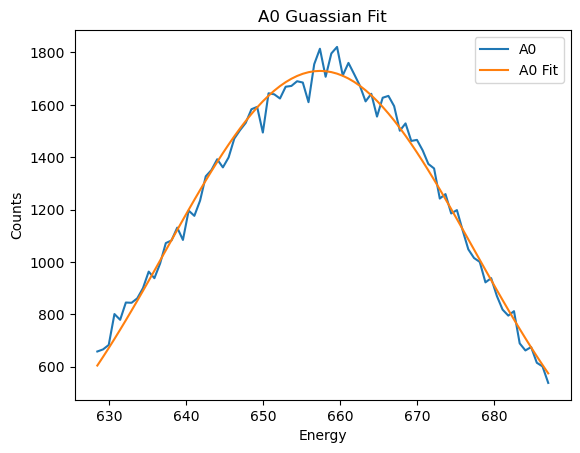

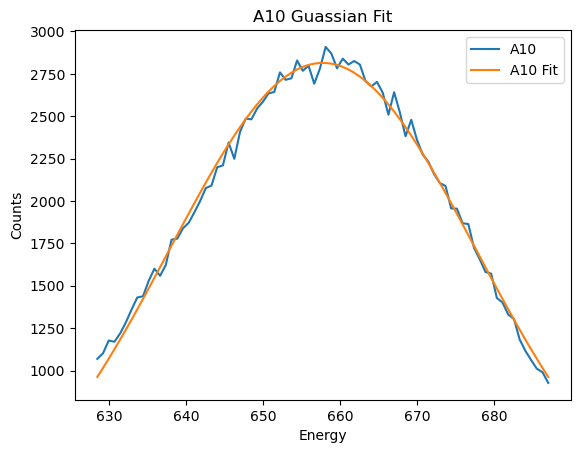

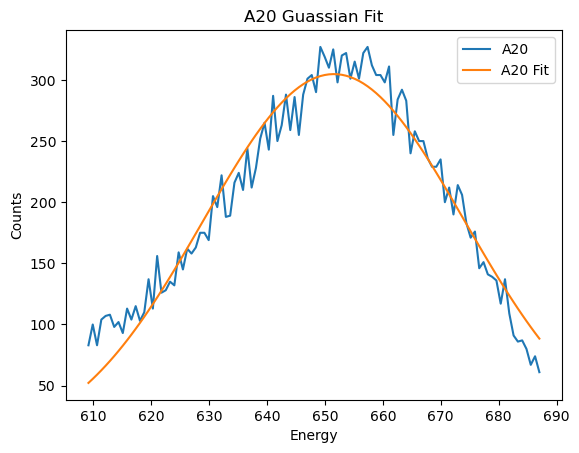

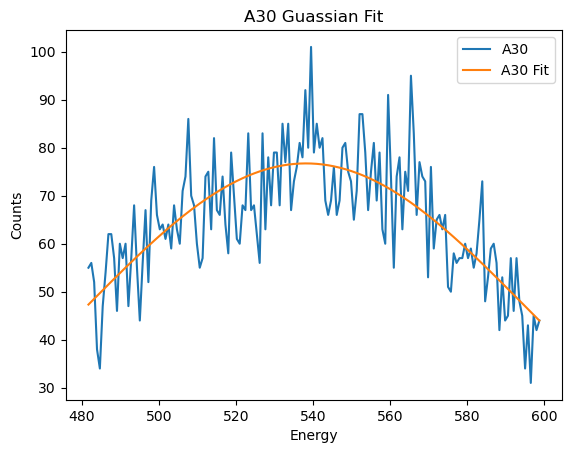

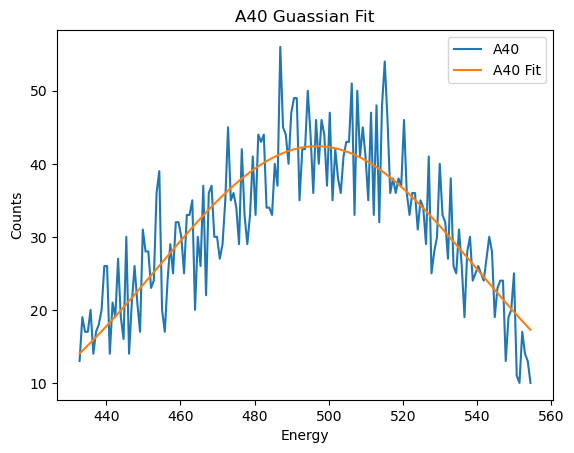

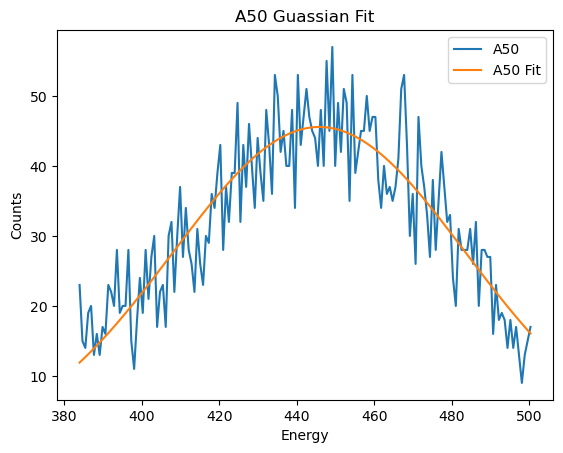

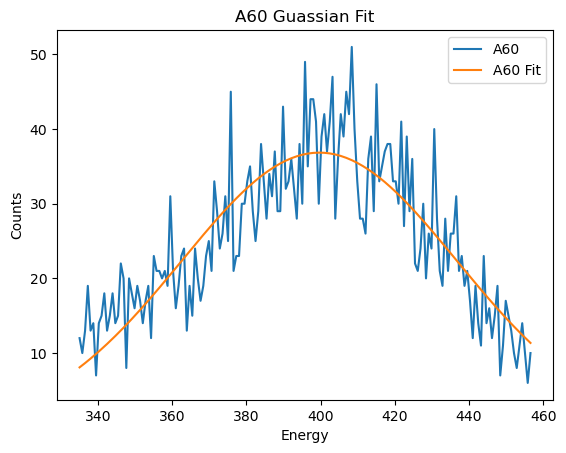

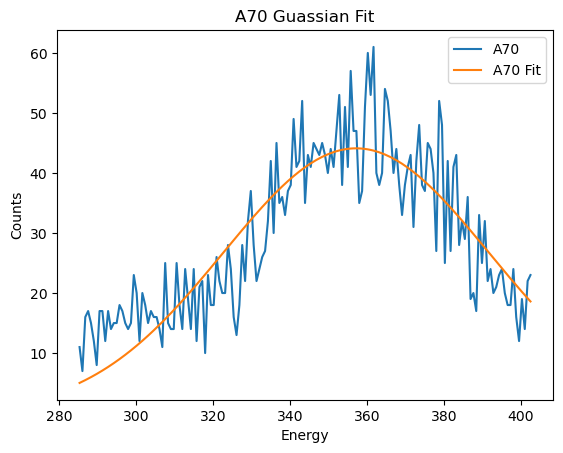

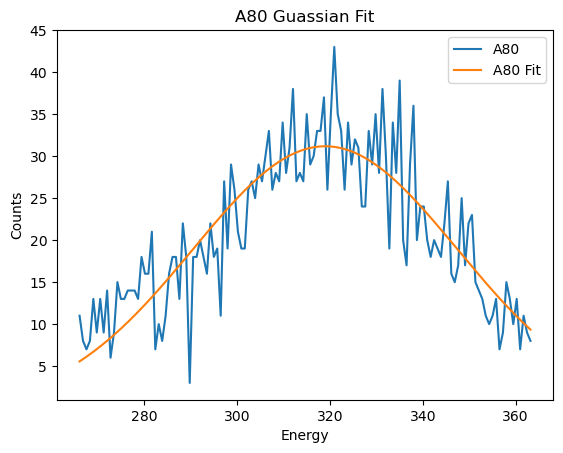

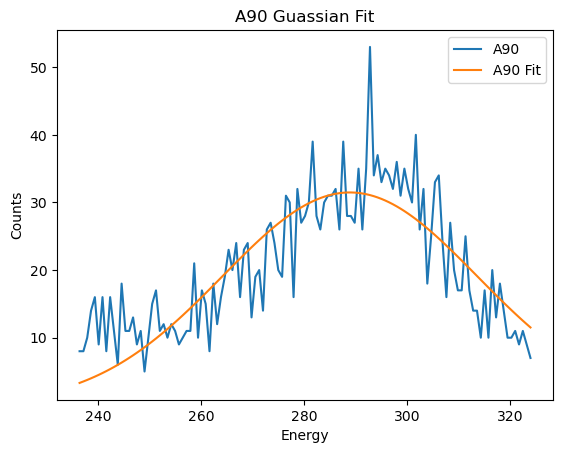

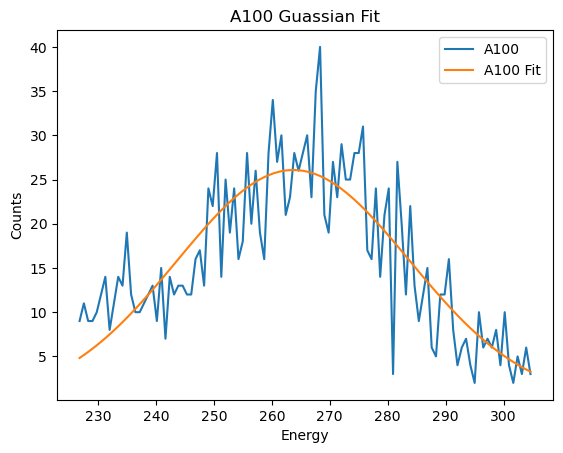

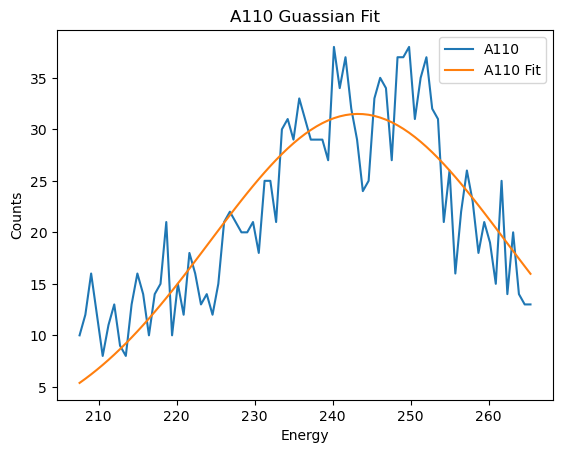

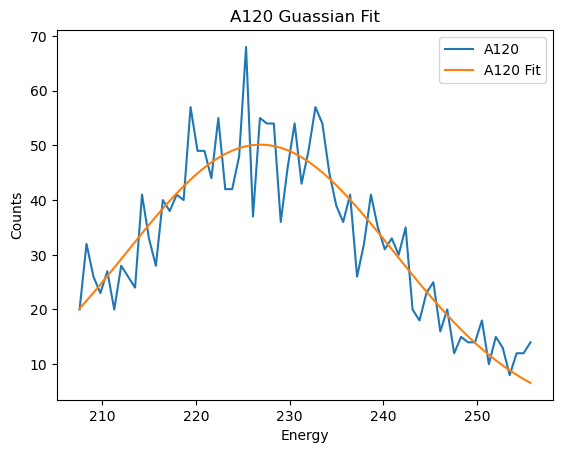

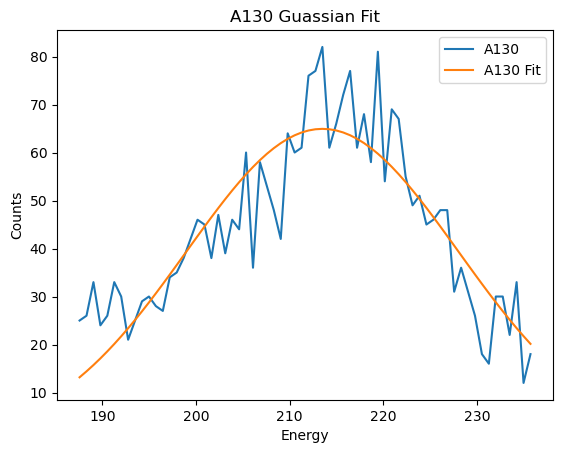

In [8]:

plot_all_S1_fits(trimmed_info)

Finally, we have to plot E/E' over 1/cos(theta)
our code starts by calculating E/E'(with uncertainty)and 1-cos(theta) as new Collumns, then runs a fit on the data and plots it.

,Angle,Mean,Sigma,Unc Mean,Unc Sigma,E/E',Unc E/E',1-cos(theta)
0,0,657.394628,19.947995,0.115181,0.152028,1.007005,0.000174,0.000000
1,10,657.734850,19.976783,0.087190,0.115235,1.006485,0.000132,0.015192
2,20,651.549510,22.544255,0.297163,0.348600,1.016039,0.000449,0.060307
3,30,538.220783,57.446231,1.139675,2.108575,1.229979,0.001722,0.133975
4,40,496.748752,42.972681,0.895040,1.220776,1.332666,0.001352,0.233956
5,50,445.773371,37.751681,0.752107,0.956671,1.485060,0.001136,0.357212
6,60,399.634340,37.096402,0.894500,1.088788,1.656514,0.001351,0.500000
7,70,357.175283,34.452495,0.947521,1.113038,1.853432,0.001431,0.657980
8,80,318.976146,28.477765,0.777544,0.920189,2.075390,0.001175,0.826352
9,90,288.873338,24.697769,0.893954,1.033815,2.291662,0.001350,1.000000


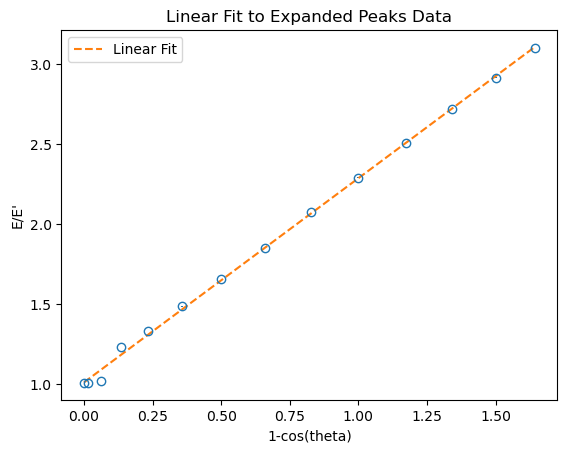

1.278274859394526 0.013307449407313217 1.009528984622438 0.01163228924758504


In [9]:
E = 662
sig_E = 0
peaks = dl.expand_df(peaks, E, sig_E)
display(peaks)
slope, unc_slope, intercept, unc_intercept = linear_fit_plot(peaks[:])
print(slope, unc_slope, intercept, unc_intercept)

In [21]:
print(unc_slope)
slope_ = ufloat(slope, unc_slope)
mass = mass_from_slope(slope_)
print(f"{mass}")

print((mass/0.511)*100 - 100)

0.013307449407313217
0.518+/-0.005
1.3+/-1.1
